## Astronomy 406 "Computational Astrophysics" (Fall 2017)

### Week 11: Gaussian Mixture Modeling

<b>Reading:</b> notes below, as well as [$\S$15.8](https://umich.instructure.com/files/5261921/download?download_frd=1) of [Numerical Recipes](http://numerical.recipes/), and $\S$5.8 of [Machine Learning](http://www.astroml.org/).

An observed univariate distribution can be modeled as a linear combination of simple analytical functions. A common method is to take a sum of $K$ Gaussian modes.  The probability of observing a point $x_n$ is

$$
P(x_n) = \sum_{k=1}^{K} \, p_k \, N(x_n \,|\, \mu_k,\sigma_k)
       = \sum_{k=1}^{K} p_k \, {1\over \sqrt{2\pi}\, \sigma_k} 
          \exp\left(-{(x_n-\mu_k)^2 \over 2\, \sigma_k^2}\right),
$$

where $p_k$ are the weights of each mode $k$.  The likelihood of observing the whole data set is ${\cal L} = \prod_{n} P(x_n)$.

Our goal is to reconstruct the parameters of the Gaussians ($\mu_k, \sigma_k, p_k$).  We will use a very efficient <b>Expectation-Maximization</b> algorithm to maximize the likelihood of data given the model:
$$ 
\log{\cal L} = \sum_{n=1}^{N} \log P(x_n).
$$

It works by successive approximation. The weight of each group $k$ in data point $n$ is given by
$$
p_{nk} = p_k \, {1\over \sqrt{2\pi}\, \sigma_k} 
          \exp\left(-{(x_n-\mu_k)^2 \over 2\, \sigma_k^2}\right) \times {1\over p(x_n)}.
$$

This is the <b>E-step</b>.  
The new estimates of the parameters are given by 
$$
\sigma_k^2 = {\sum_n p_{nk} \, (x_n - \mu_k)^2 \over \sum_n p_{nk}}, \qquad
  \mu_k = {\sum_n p_{nk} \, x_n \over \sum_n p_{nk}}, \qquad
  p_k = {1\over N} \sum_n p_{nk}.
$$

This is the <b>M-step</b>.  
Start with some initial guesses for the parameters (they do not need to be close to the expected values), and iterate E and M steps until convergence of the likelihood $\log{\cal L}$. It usually converges very fast.

In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 90
import numpy as np
import matplotlib.pyplot as plt
import random

from scipy.interpolate import UnivariateSpline
from scipy.integrate import quad

Let's consider the metallicity distribution of globular clusters again, and split in into two modes.

In [2]:
x = np.loadtxt('DataFiles/gc.dat', usecols=(0,), unpack=True)

The routine below is a simple implementation of the EM algorithm.

In [3]:
def GMM_simple(mu, sig, pk, x):
    Kmodes = len(mu)
    logL = 999.
    logL1 = 99.
    iter = 0
    pnk = np.zeros([Kmodes, len(x)])

    while abs(logL-logL1) > 1.e-10:
        # E-step
        iter += 1
        pxn = np.zeros(len(x))
        for k in xrange(Kmodes):
            pxn += pk[k]/np.sqrt(2.*np.pi)/sig[k]*np.exp(-((x-mu[k])/sig[k])**2/2.)

        logL1 = logL
        logL = np.sum(np.log(pxn))

        # M-step
        for k in xrange(Kmodes):     
            pnk[k] = pk[k]/np.sqrt(2.*np.pi)/sig[k]*np.exp(-((x-mu[k])/sig[k])**2/2.)/pxn

        for k in xrange(Kmodes):
            w = pnk[k]/sig[k]**2
            sig2k = np.average((x-mu[k])**2, weights=w)
            sig[k] = np.sqrt(sig2k)
            mu[k] = np.average(x, weights=w)
            pk[k] = np.average(pnk[k])
        
    return logL, mu, sig, pk

In [4]:
logL, mu, sig, pk = GMM_simple([-1.,0.], [1.,1.], [0.5,0.5], x)

print 'mu =', mu
print 'sig =', sig
print 'pk =', pk

mu = [-1.607397074391556, -0.57721231686507291]
sig = [0.32073131431637841, 0.28563108794622216]
pk = [0.69809872122850081, 0.30190127877149919]


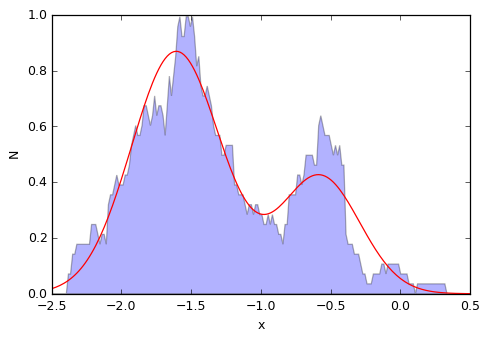

In [5]:
def kde_tophat( data, x, h ):
    y = (abs(x - data[:,None]) <= h).astype(float)
    return y.sum(0)/(2*h*len(data))

def pdf_gauss( x, mu, s ):
    return np.exp(-((x-mu)/s)**2/2.)/(np.sqrt(2.*np.pi)*s)

xx = np.linspace(-2.5, 0.5, num=200)
yy = np.zeros(len(xx))
for k in xrange(len(mu)):
    yy += pk[k]*pdf_gauss(xx,mu[k],sig[k])
        
plt.xlabel('x')
plt.ylabel('N')
plt.fill(xx, kde_tophat(x,xx,0.1), alpha=0.3)
plt.plot(xx, yy, 'r-')
plt.show()

How do we choose the right number of modes to describe our data set?  It is a non-trivial problem, which is a part of the general problem of <b>model selection</b>.  We consider some simple rules first.

The Aikake information criterion (derived from information theory):

$\mathrm{AIC} \equiv -2\ln{{\cal L}_{max}} + 2K + {2K (K+1) \over N-K-1}$.

The Bayesian information criterion:

$\mathrm{BIC} \equiv -2\ln{{\cal L}_{max}} + K \ln{N}$.

In principle, the likelihood ${\cal L}$ can always be improved by increasing the number of free parameters. However, we prefer a simpler model over a more complex model if the simpler model can describe the data almost as well. Thus both criteria penalize the likelihood for the number of model parameters $K$. The most appropriate model would minimize AIC and BIC.

<b>Exercise 1:</b> Choose the right number of modes for our data set based on AIC and BIC.

C:\Users\Adam2\Anaconda\lib\site-packages\ipykernel\__main__.py:16: RuntimeWarning: divide by zero encountered in log
C:\Users\Adam2\Anaconda\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars


[]
[-1.29638298]
[-1.60739706 -0.57721228]
[-0.57367714 -0.57093081 -1.59359621]


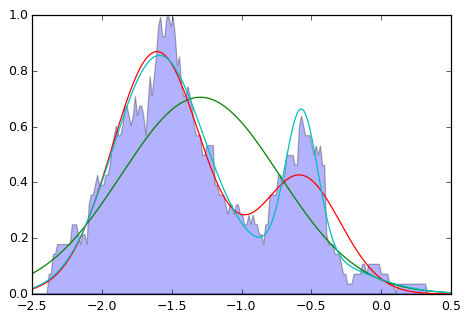

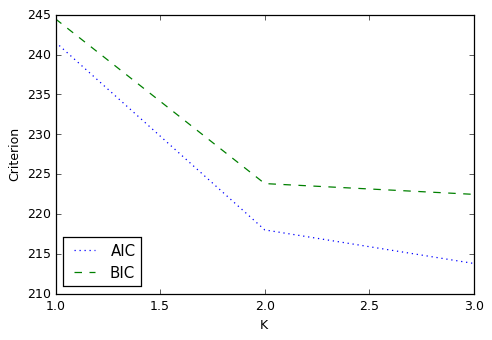

In [6]:
AIC = []
BIC = []
K_list = []

sample = np.arange(0.1, 50, 0.01)

for K in range(4):   
    #logL, mu, sig, pk = GMM_simple(random.sample(sample, i), random.sample(sample, i), random.sample(sample, i), x)
    logL, mu, sig, pk = GMM_simple(np.random.rand(K), np.ones(K), np.ones(K) / (1. * K), x)
    #logL, mu, sig, pk = GMM_simple([0.5]*i, [0.5]*i, [0.5]*i, x)    
    
    K_list.append(K)
    N = len(x)
    max_like = -2. * logL

    AIC.append(max_like + 2.*K + (2.*K * (K + 1.)) / (N - K - 1.))
    BIC.append(max_like + K * np.log(N))

#     xx = np.linspace(-2.5, 0.5, num=200)
#     yy = np.zeros(len(xx))
#     for k in xrange(K):
#         yy += pk[k]*pdf_gauss(xx,mu[k],sig[k])

#     plt.xlabel('x')
#     plt.ylabel('N')
#     plt.fill(xx, kde_tophat(x,xx,0.1), alpha=0.3)
#     plt.plot(xx, yy, 'r-')

    yy = np.zeros(len(xx))

    for k in xrange(len(mu)):
        yy += pk[k]*pdf_gauss(xx,mu[k],sig[k])
    
    plt.plot(xx, yy, '-')
    
    print mu

plt.fill(xx, kde_tophat(x,xx,0.1), alpha=0.3)
plt.show()
    
plt.plot(K_list, AIC, linestyle = ':', label = 'AIC')
plt.plot(K_list, BIC, linestyle = '--', label = 'BIC')

plt.ylabel('Criterion')
plt.xlabel('K')
plt.legend(loc = 3)
plt.show()

We will use the [GMM algorithm](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) provided by <b>sklearn</b> package and take examples of [Figure 4.2](http://www.astroml.org/book_figures/chapter4/fig_GMM_1D.html) and [Figure 6.6](http://www.astroml.org/book_figures/chapter6/fig_EM_metallicity.html) in ML.

Read also [useful information](http://scikit-learn.org/stable/modules/mixture.html) on the implementation of GMM in sklearn.

In [7]:
import sklearn
print sklearn.__version__
from sklearn.mixture import GMM

0.16.1


mu = [-1.65622398 -0.71164212]
sig = [ 0.29779557  0.3827309 ]
pk = [ 0.61904731  0.38095269]


ValueError: could not broadcast input array from shape (200,2) into shape (200)

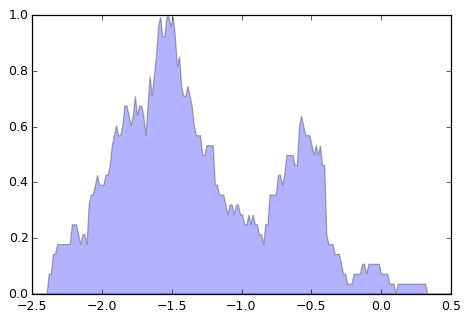

In [8]:
K = np.arange(1, 6)
models = [None for i in K]

X = x.reshape(-1,1) # GaussianMixture requires a 2D array as input

for i in range(len(K)):
    models[i] = GMM(K[i], random_state=1, covariance_type='full', n_init=10).fit(X)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]
logL = [m.score(X) for m in models]

#for i in range(len(K)):
#    print 'K = %d  AIC = %.1f  BIC = %.1f  logL = %.3f'%(K[i], AIC[i], BIC[i], logL[i])

gmm_best = models[np.argmin(AIC)] # choose the best model with smallest AIC

print 'mu =', gmm_best.means_.flatten()
print 'sig =', np.sqrt(gmm_best.covars_.flatten())
print 'pk =', gmm_best.weights_.flatten()


xx = np.linspace(-2.5, 0.5, num=200)
XX = xx.reshape(-1,1)
logprob = gmm_best.score_samples(XX)

plt.fill(xx, kde_tophat(x,xx,0.1), alpha=0.3)
plt.plot(xx, np.exp(logprob), '-k')
for m, C, w in zip(gmm_best.means_, gmm_best.covars_.flatten(), gmm_best.weights_):
    plt.plot(xx, w*pdf_gauss(xx,m,np.sqrt(C)), '--r')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.show()

In [ ]:
plt.plot(K, AIC, 'r-', label='AIC')
plt.plot(K, BIC, 'b--', label='BIC')
plt.xlabel('number of components')
plt.ylabel('information criterion')
plt.legend(loc=2, frameon=False)
plt.show()

### Drawing from a distribution

It is often useful to be able to generate a simulated random sample drawn from a specified distribution. This distribution may be analytical or discrete, such as an existing data sample.  A simulated sample can be used for comparison with data, in a technique called <i>parametric bootstrap</i> (see Week 7 notebook).

A general and very simple way to generate a simulated sample is the <b>transformation method</b>, described in [$\S$7.3.2](https://umich.instructure.com/files/5261916/download?download_frd=1) of [Numerical Recipes](http://www.nr.com) or $\S$3.7 of [Machine Learning](http://www.astroml.org/). [Figure 3.25](http://www.astroml.org/book_figures/chapter3/fig_clone_distribution.html) provides a good illustration.

In the transformation method, you draw a random number $r$, uniformly distributed between 0 and 1, and interpolate the cumulative distribution function $F(<x) = \int_{-\infty}^{x} p(x)dx$ to find $x$ corresponding to $F(<x) = r$. 

<b>Exercise 2:</b> Create a mock data set of $N=200$ random variables $x$ corresponding to the sum of two Gaussians, with $\mu_1 = -1.5$, $\mu_2 = -0.5$, $\sigma_1 = \sigma_2 = 0.3$, $p_1 = 0.7$, $p_2 = 0.3$. The cumulative function $F(<x)$ can be expressed as a sum of the complementary error functions.  Be careful with the normalization and the argument of <tt>scipy.special.erfc</tt>.  If in doubt, check your result with direct integration of $p(x)$. 
After creating the data set, run GMM on it and check how well you recover the input parameters.

In [ ]:
#Modules needed

from scipy.special import erfc
from scipy.misc import derivative

In [ ]:
# your code - ML Figure 3.25
def pdf_gauss( x, mu, s ):
    return np.exp(-((x-mu)/s)**2/2.)/(np.sqrt(2.*np.pi)*s)

def gauss_sum(x, mu, sigma, p):
    gauss = []
    
    for k in range(len(mu)):
        gauss.append(p[k] * pdf_gauss(x, mu[k], sigma[k]))
    
    return gauss[0] + gauss[1]

def erfc_ex(x, mu, sigma, p):
    err_func = []
    
    for k in range(len(mu)):
        mu_k = mu[k]
        sigma_k = sigma[k]
        p_k = p[k]
        err_func.append(p[k] * erfc((mu[k] - x) / sigma[k]))
    
    return err_func[0] + err_func[1]
        
mu = [-1.5, -0.5]
sigma = [0.3, 0.3]
p = [0.7, 0.3]
gauss = []

xx = np.linspace(-4, 4, num=200)

#for k in range(len(mu)):
#    gauss.append(p[k] * pdf_gauss(xx, mu[k], sigma[k]))

#gauss_sum = gauss[0] + gauss[1]

#Checking form of erfc with gaussian...

plt.plot(xx, gauss_sum(xx, mu, sigma, p))
plt.show()

err_dat = np.array([-0.7*np.sqrt(np.pi)/2.*np.sqrt(2*np.pi*0.3)*derivative(erfc, (i+1.5)/0.3)\
                    -0.3*np.sqrt(np.pi)/2.*np.sqrt(2*np.pi*0.3)*derivative(erfc, (i+0.5)/0.3) for i in xx])
plt.plot(xx, err_dat)
plt.show()


err_dat = erfc_ex(xx, mu, sigma, p)
#-0.7*erfc((xx+1.5)/0.3)-0.3*erfc((xx+0.5)/0.3)
plt.plot(xx, err_dat)
plt.show()



#Refer to https://math.stackexchange.com/questions/1439897/where-does-mean-and-standard-deviation-go-in-the-error-function


Now let's look at an example of GMM decomposition for a multivariate sample.

In [ ]:
feh, m, d = np.loadtxt('DataFiles/gc.dat', unpack=True)
logd = np.log10(d)
X = np.vstack([feh, logd]).T

In [ ]:
N = np.arange(1, 10)
models = [None for n in N]

for i in range(len(N)):
    models[i] = GMM(N[i], covariance_type='full').fit(X)

AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

i_best = np.argmin(BIC)
gmm_best = models[i_best]
print 'best fit converged:', gmm_best.converged_
print 'number of interations =', gmm_best.n_iter_
print 'BIC: N components = %i' % N[i_best]

plt.plot(N, AIC, 'r-', label='AIC')
plt.plot(N, BIC, 'b--', label='BIC')
plt.xlabel('number of components')
plt.ylabel('information criterion')
plt.legend(loc=2, frameon=False)
plt.show()

In [ ]:
from astroML.plotting.tools import draw_ellipse

plt.scatter(feh, logd)
plt.xlabel('[Fe/H]')
plt.ylabel('log d (kpc)')

for mu, C, w in zip(gmm_best.means_, gmm_best.covars_, gmm_best.weights_):
    draw_ellipse(mu, C, scales=[2], fc='none', ec='k')